In [ ]:
#pip install matplotlib

In [ ]:
# pip install pydub

In [ ]:
# pip install datasets

In [12]:
import librosa
import librosa.display
import IPython.display as ipd
from pydub import AudioSegment
from pydub.utils import mediainfo
import scipy
import numpy as np
import matplotlib.pyplot as plt

/Users/karenlu/opt/miniconda3/envs/audio_env/lib/python3.13/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [15]:
from datasets import load_dataset
dialect_corpus = load_dataset("TingChen-ppmc/Shanghai_Dialect_Conversational_Speech_Corpus")

/Users/karenlu/opt/miniconda3/envs/audio_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 100%|██████████| 3792/3792 [00:00<00:00, 5257.69 examples/s]


In [16]:
dialect_corpus['train'][1]

{'audio': {'path': 'A0002_S0003_0_G0003_G0004_1.WAV',
  'array': array([0.00137329, 0.00094604, 0.        , ..., 0.00183105, 0.00213623,
         0.0017395 ], shape=(43040,)),
  'sampling_rate': 16000},
 'gender': 'female',
 'speaker_id': 'G0004',
 'transcription': '北京爱数智慧语音采集'}

## Trying out normalization and plotting it out 

In [17]:
audio_data_1 = dialect_corpus['train'][1]['audio']['array']

In [18]:
normalized_audio_1 = librosa.util.normalize(audio_data_1)

In [19]:
sampling_rate = dialect_corpus['train'][1]['audio']['sampling_rate']

In [20]:
time = np.linspace(
    0, len(normalized_audio_1) / sampling_rate, num=len(normalized_audio_1))

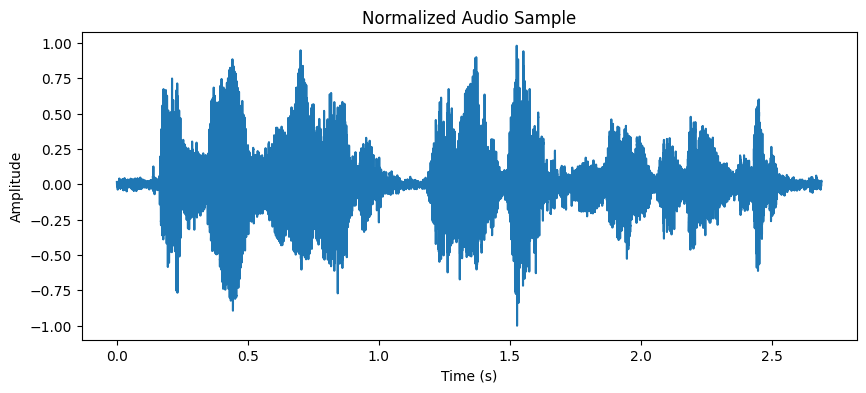

In [21]:

# Plot the audio sample
plt.figure(figsize=(10, 4))
plt.plot(time, normalized_audio_1)
plt.title('Normalized Audio Sample')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


## preemphasizing audio signal

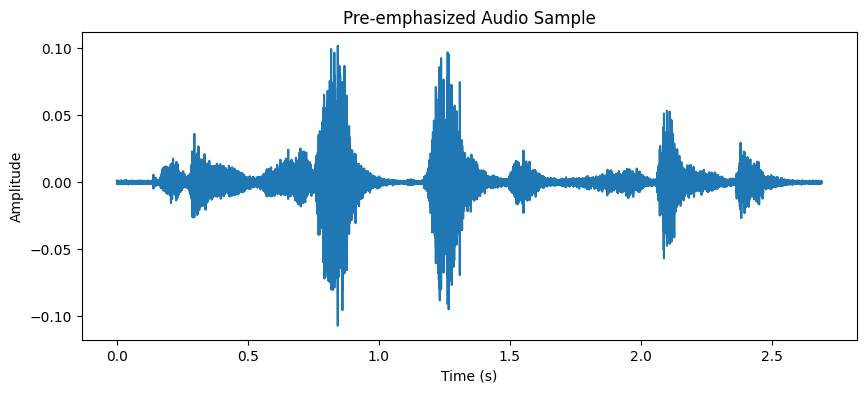

In [22]:
#pre-emphasis filter
pre_emphasis = 0.97
emphasized_audio = np.append(audio_data_1[0], audio_data_1[1:] - pre_emphasis * audio_data_1[:-1])

time = np.linspace(0, len(emphasized_audio) / sampling_rate, num=len(emphasized_audio))
plt.figure(figsize=(10, 4))
plt.plot(time, emphasized_audio)
plt.title('Pre-emphasized Audio Sample')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

## Fast Fourier Transform

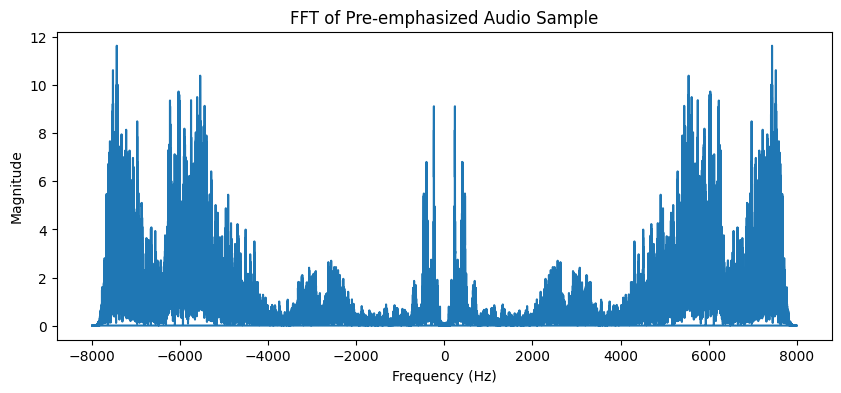

In [23]:
fft_result = np.fft.fft(emphasized_audio)

#compute the frequency bins
freq_bins = np.fft.fftfreq(len(emphasized_audio), 1/sampling_rate)

#plot
plt.figure(figsize=(10, 4))
plt.plot(freq_bins, np.abs(fft_result))
plt.title('FFT of Pre-emphasized Audio Sample')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

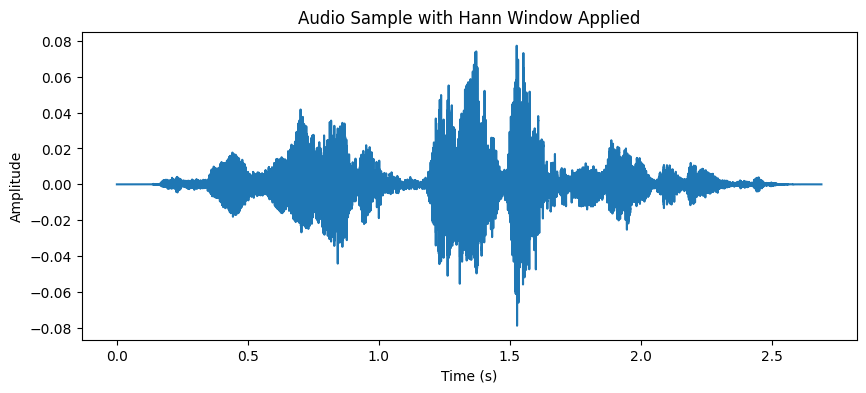

In [24]:
from scipy.signal import windows

# Apply Hann window
hann_window = windows.hann(len(audio_data_1))
windowed_audio = audio_data_1 * hann_window

# Create x-axis timeframe for reference in plot
time = np.linspace(0, len(windowed_audio) / sampling_rate, num=len(windowed_audio))

# Plot the windowed audio sample
plt.figure(figsize=(10, 4))
plt.plot(time, windowed_audio)
plt.title('Audio Sample with Hann Window Applied')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()



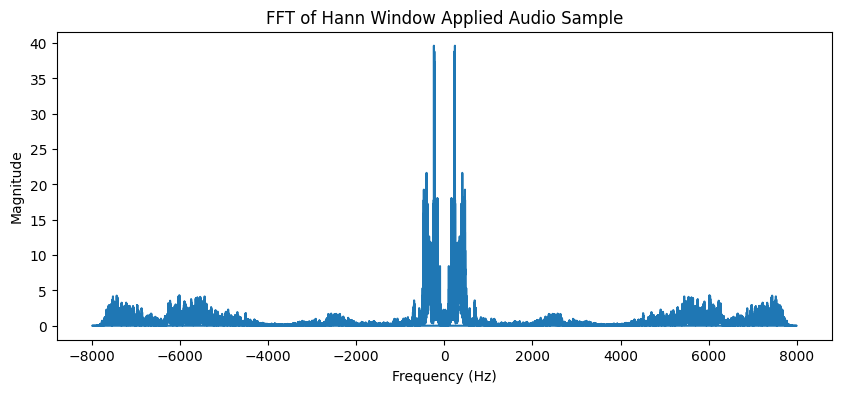

In [25]:
#fft on windowed
fft_result = np.fft.fft(windowed_audio)
freq_bins = np.fft.fftfreq(len(windowed_audio), 1/sampling_rate)

#plot
plt.figure(figsize=(10, 4))
plt.plot(freq_bins, np.abs(fft_result))
plt.title('FFT of Hann Window Applied Audio Sample')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

## Feature extraction test: Spectrogram and MFCC

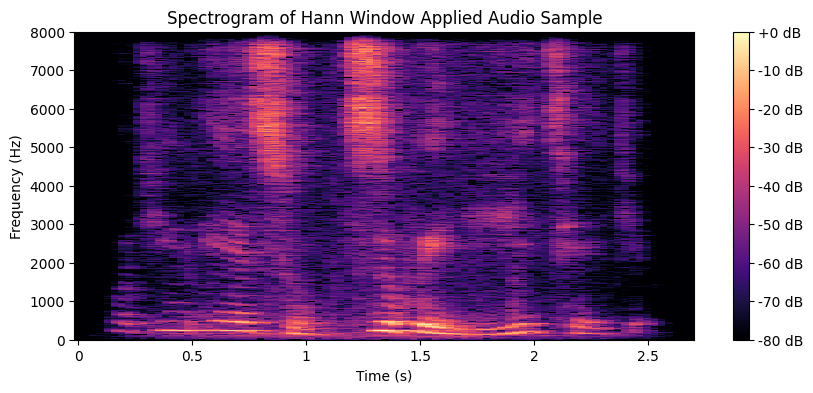

In [26]:
# plot
plt.figure(figsize=(10, 4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(windowed_audio)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Hann Window Applied Audio Sample')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

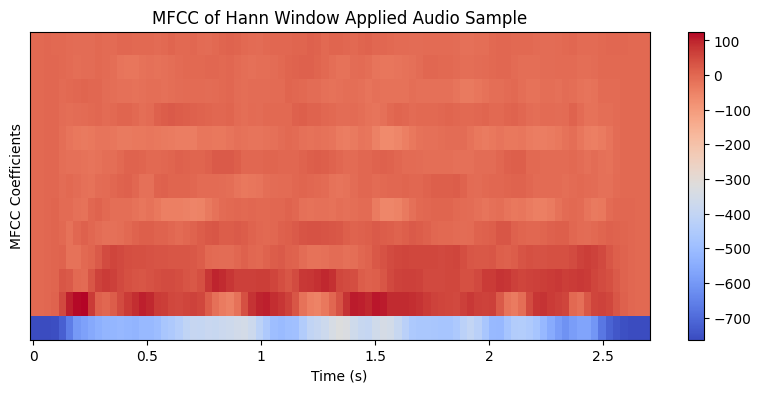

In [27]:
#mel freq cepstral coeffs
mfccs = librosa.feature.mfcc(y=windowed_audio, sr=sampling_rate, n_mfcc=13)

# Plot MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sampling_rate, x_axis='time')
plt.colorbar()
plt.title('MFCC of Hann Window Applied Audio Sample')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.show()

In [17]:
wav = librosa.feature.inverse.mfcc_to_audio(mfccs)
ipd.Audio(wav, rate = 16000)

#sounds horrendous lol but may capture the key features needed for classification 

### Next steps: get Mandarin equivalent of the sounds (use text to speech?) 

## Testing existing denoising models 
Add noise to audio 

In [ ]:
# pip install soundfile

Note: you may need to restart the kernel to use updated packages.


In [29]:
import numpy as np
import soundfile as sf

In [30]:
def add_noise(clean: np.ndarray,
              noise: np.ndarray,
              snr_db: float) -> np.ndarray:
    """
    Scale and add `noise` to `clean` to achieve a target SNR (in dB).
    If noise is shorter than clean, it will be tiled/repeated.
    """
    # 1) match lengths
    if noise.shape[0] < clean.shape[0]:
        repeats = int(np.ceil(clean.shape[0] / noise.shape[0]))
        noise = np.tile(noise, repeats)
    noise = noise[: clean.shape[0]]

    # 2) compute power
    def rms(x): return np.sqrt(np.mean(x**2))
    clean_rms = rms(clean)
    noise_rms = rms(noise)

    # 3) compute required noise scaling
    snr_linear = 10 ** (snr_db / 20)
    desired_noise_rms = clean_rms / snr_linear
    scale = desired_noise_rms / (noise_rms + 1e-8)

    # 4) mix
    noisy = clean + scale * noise
    # 5) clip if needed
    return np.clip(noisy, -1.0, +1.0)

In [31]:
# audio_data_1 = dialect_corpus['train'][1]['audio']['array']
# sampling_rate = dialect_corpus['train'][1]['audio']['sampling_rate']

clean = audio_data_1
sr = sampling_rate

In [32]:
# —— Mode A: white Gaussian noise —— 
white_noise = np.random.randn(len(clean))
noisy_white = add_noise(clean, white_noise, snr_db=5)   # 5 dB SNR

In [33]:
sf.write("noisy_white.wav", noisy_white, sr)

In [34]:
ipd.Audio(noisy_white, rate = 16000)

In [35]:
# —— Mode B: real-world noise WAV —— 
from datasets import load_dataset

ds = load_dataset("danavery/urbansound8K")

Generating train split: 100%|██████████| 8732/8732 [00:23<00:00, 369.84 examples/s]


In [ ]:
children_playing = ds['train'][1]
children_playing_audio = children_playing['audio']['array']

In [46]:
children_playing['audio']['path']

'100263-2-0-117.wav'

In [ ]:
# pip install dask

In [ ]:
#use dask or read parquet file as a workaround
# import dask.dataframe as dd
# urbansound_df = dd.read_parquet("train-00005-of-00016-55ef1a0a51149c01.parquet")

In [ ]:
# urbansound_df

In [ ]:
noisy_real = add_noise(clean, children_playing_audio, snr_db = 5)   # 5 dB SNR

In [ ]:
sf.write("noisy_real.wav", noisy_real, sr)

In [72]:
# ipd.Audio(children_playing['audio']['array'], rate = 16000)
ipd.Audio('noisy_real.wav', rate=44100)

In [ ]:

noise_wav, noise_sr = sf.read(ds['train'][1]['audio']['path'], dtype='float32')
if noise_sr != sr:
    import librosa
    noise_wav = librosa.resample(noise_wav, orig_sr=noise_sr, target_sr=sr)
noisy_real = add_noise(clean, noise_wav, snr_db=0)      # very noisy

sf.write("noisy_real.wav",  noisy_real,  sr)

LibsndfileError: Error opening '100263-2-0-117.wav': System error.

## Test denoising models

In [52]:
#!pip install torch
# !pip install torchaudio
# !pip install transformers

  Using cached transformers-4.52.4-py3-none-any.whl.metadata (38 kB)
   ---------------------------------------- 0.0/10.5 MB ? eta -:--:--
   ------------------- -------------------- 5.0/10.5 MB 24.4 MB/s eta 0:00:01
   ---------------------------------------  10.2/10.5 MB 27.3 MB/s eta 0:00:01
   ---------------------------------------- 10.5/10.5 MB 19.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ------------------------------ --------- 1.8/2.4 MB 24.7 MB/s eta 0:00:01
   ---------------------------------------- 2.4/2.4 MB 14.7 MB/s eta 0:00:00

   ---------------------------------------- 0/4 [safetensors]
   ---------- ----------------------------- 1/4 [regex]
   ---------- ----------------------------- 1/4 [regex]
   -------------------- ------------------- 2/4 [tokenizers]
   -------------------- ------------------- 2/4 [tokenizers]
   -------------------- ------------------- 2/4 [tokenizers]
   -------------------- ------------------- 

In [53]:
#noisy data is "noisy_white.wav"
import torch
import torchaudio
# import speechbrain as sb #can't install right now
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor
# import os
# import glob

In [55]:
# !pip install noisereduce
import noisereduce as nr

In [56]:
def preprocess_audio(path, target_sr=16000):
    """
    Load, mono-mix, and resample an audio file.
    Returns: (waveform: Tensor[1, T], sample_rate)
    """
    wav, sr = torchaudio.load(path)                   # [C, T]
    if wav.size(0) > 1:                                # downmix to mono
        wav = wav.mean(dim=0, keepdim=True)
    if sr != target_sr:
        wav = torchaudio.transforms.Resample(sr, target_sr)(wav)
        sr = target_sr
    return wav, sr

In [59]:
wav, sr = preprocess_audio("noisy_white.wav")

In [58]:
def denoise_audio(wav: torch.Tensor, sr: int):
    """
    Apply spectral-gating denoising from noisereduce.
    Input: wav [1, T]
    Output: wav [1, T]
    """
    y = wav.squeeze().numpy()                         # → (T,)
    y_denoised = nr.reduce_noise(y=y, sr=sr)
    return torch.from_numpy(y_denoised).unsqueeze(0)

In [60]:
clean_wav = denoise_audio(wav, sr)

In [64]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-xlsr-53")
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-large-xlsr-53")

SSLError: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /facebook/wav2vec2-large-xlsr-53/resolve/main/preprocessor_config.json (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1028)')))"), '(Request ID: c6510953-a810-4ed2-b646-0e26852c662f)')

In [61]:
def classify_language(wav: torch.Tensor, sr: int):
    """
    Run wav2vec2-based dialect classifier.
    Returns the predicted class index.
    """
    samples = wav.squeeze().numpy()                   # (T,)
    inputs  = processor(samples, sampling_rate=sr,
                        return_tensors="pt", padding=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    return int(logits.argmax(-1))

In [ ]:
predicted_id   = classify_language(clean_wav, sr)
print(f"Dialect ID {predicted_id}")

## Test classification models (general)

## Test classification models (dialogue specific)